## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.adult.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [ ]:
clear_df = df[df != '?'].dropna().reset_index()
clear_df

,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
15343,16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
15344,16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
15345,16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [ ]:
y = pd.Series(clear_df['>50K,<=50K'].factorize()[0])

In [ ]:
X_cat = clear_df.select_dtypes(include='object').drop(columns = ['>50K,<=50K'])
X_num = clear_df.select_dtypes(exclude='object')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_num, y, random_state=42, test_size=0.2)

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

best n_neighbors: {'n_neighbors': 7}
best score: 0.6054501071593951 



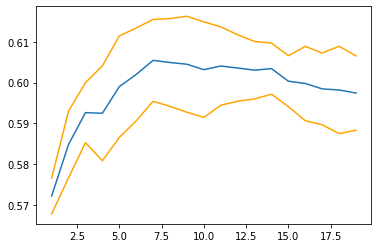

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, KFold
import warnings
warnings.filterwarnings("ignore")
kf = KFold(5, random_state=42, shuffle=True)

clf0 = KNeighborsClassifier()
params0 = {'n_neighbors': np.arange(1, 20, 1)}
grid = GridSearchCV(clf0, params0, cv=kf, scoring='roc_auc', )
grid.fit(X_num, y)
print(f'best n_neighbors: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

import matplotlib.pyplot as plt
scores = grid.cv_results_['mean_test_score']
stds = []
for i in range(4, -1, -1):
  stds.append(grid.cv_results_[f'split{i}_test_score'])
stds = np.array(stds).std(0)
upper = scores + stds
lower = scores - stds
plt.plot(np.arange(1, 20, 1), scores)
plt.plot(np.arange(1, 20, 1), upper, color='orange')
plt.plot(np.arange(1, 20, 1), lower, color='orange')

best max_depth: {'max_depth': 8}
best score: 0.8375651081470383 



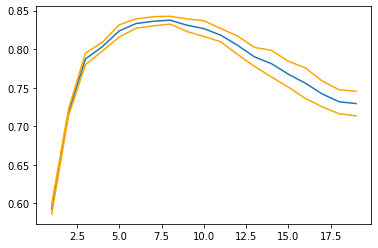

In [ ]:
clf1 = DecisionTreeClassifier(random_state=42)
params1 = {'max_depth': np.arange(1, 20, 1)}
grid = GridSearchCV(clf1, params1, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best max_depth: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

scores = grid.cv_results_['mean_test_score']
stds = []
for i in range(4, -1, -1):
  stds.append(grid.cv_results_[f'split{i}_test_score'])
stds = np.array(stds).std(0)
upper = scores + stds
lower = scores - stds
plt.plot(np.arange(1, 20, 1), scores)
plt.plot(np.arange(1, 20, 1), upper, color='orange')
plt.plot(np.arange(1, 20, 1), lower, color='orange')

best loss: {'loss': 'log'}
best score: 0.6245556741342515


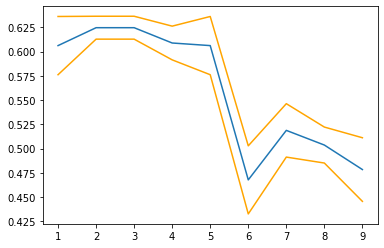

In [ ]:
clf2 = SGDClassifier(random_state=42)
params2 = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge',
                    'perceptron', 'squared_error', 'huber', 
                    'epsilon_insensitive', 'squared_epsilon_insensitive')}
grid = GridSearchCV(clf2, params2, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best loss: {grid.best_params_}')
print(f'best score: {grid.best_score_}')

scores = grid.cv_results_['mean_test_score']
stds = []
for i in range(4, -1, -1):
  stds.append(grid.cv_results_[f'split{i}_test_score'])
stds = np.array(stds).std(0)
upper = scores + stds
lower = scores - stds
plt.plot(np.arange(1, 10, 1), scores)
plt.plot(np.arange(1, 10, 1), upper, color='orange')
plt.plot(np.arange(1, 10, 1), lower, color='orange')

При увеличении числа соседей до опр. уровня качество растет, затем модель начинает переобучаться. 

С глубиной деревьев аналогично

'hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron' -- по этим лоссам достаточно неплохое качество

'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive' -- существенно проигрывают в качестве

Что вы можете сказать о получившихся графиках?

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

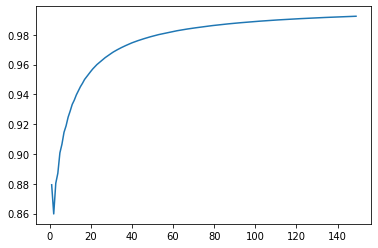

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm_notebook
np.random.seed(42)

n_trees = 150
best_est = 0
i = 0
cv_scores = np.empty((5, n_trees - 1))

for train_index, test_index in kf.split(X_num):
    X_train, X_test = X_num.iloc[train_index], X_num.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf3 = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    clf3.fit(X_num, y)
    estimators = clf3.estimators_
    test_roc_auc = np.array([])
    mean_scores = np.array([])
    for n in range(1, n_trees):
      clf3.estimators_ = np.random.choice(estimators, n)
      test_roc_auc = np.append(test_roc_auc, roc_auc_score(y_test, clf3.predict(X_test)))
      mean_scores = np.append(mean_scores, test_roc_auc.mean())
    cv_scores[i] = mean_scores
    i += 1


plt.plot(np.arange(1, n_trees, 1), cv_scores.mean(axis=0))
plt.show()

In [ ]:
best_est = np.argmax(abs(np.diff(cv_scores.mean(axis=0))) < 0.001)
clf3 = RandomForestClassifier(n_estimators=best_est, random_state=42)
best_score = cross_val_score(clf3, X_num, y, cv=kf).mean()
best_est, best_score

(26, 0.8117551049000035)

In [ ]:
# from sklearn.metrics import roc_auc_score

# clf3 = RandomForestClassifier(n_estimators=100, random_state=42)
# clf3.fit(X_train, y_train)

# train_roc_auc, test_roc_auc = [], []
# estimators = clf3.estimators_
# n_trees = 100
# best_est = 0

# for i in tqdm_notebook(range(1, n_trees + 1)):
#   clf3.estimators_ = estimators[:i]
#   train_roc_auc.append(roc_auc_score(y_train, clf3.predict(X_train)))
#   test_roc_auc.append(roc_auc_score(y_test, clf3.predict(X_test)))
#   if i > 1 and best_est == 0 and abs(test_roc_auc[-1] - test_roc_auc[-2]) < 0.001:
#     best_est = i

# plt.plot(np.arange(1, 101, 1), train_roc_auc)
# plt.show()
# plt.plot(np.arange(1, 101, 1), test_roc_auc, color='orange')
# plt.show()

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# clf4 = GradientBoostingClassifier(random_state=42)
# params4 = {'n_estimators': np.arange(10, 500, 50)}
# grid = GridSearchCV(clf4, params4, cv=kf, scoring='neg_mean_squared_error')
# grid.fit(X_num, y)
# print(f'best n_estimators: {grid.best_params_}')
# print(f'best score: {grid.best_score_} \n')
# best_grid_est = grid.best_params_['n_estimators']

# scores = grid.cv_results_['mean_test_score']
# plt.plot(np.arange(10, 500, 50), scores)

In [ ]:
# best_grid_est = grid.best_params_['n_estimators']
# best_grid_score = grid.best_score_

# best_grid_est, best_grid_score

  0%|          | 0/35 [00:00<?, ?it/s]

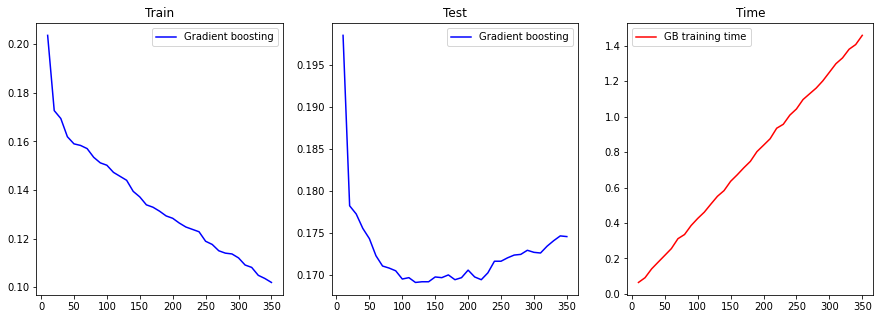

In [ ]:
from time import time
from sklearn.metrics import mean_squared_error

def get_model_scores(selected_model, n_list=np.arange(10, 360, 10), learning_rate=0.1):
  acc_train = []
  acc_test = []
  time_list = []

  n_list = n_list

  X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.8, random_state=42)

  for n in tqdm_notebook(n_list):
      model = selected_model(n_estimators=n, random_state=42)
      # у RF нет параметра learning_rate
      if type(model) == type(GradientBoostingClassifier()):
          model.learning_rate = learning_rate 
      t_start = time()
      model.fit(X_train, y_train)
      t_end = time()
      time_list.append(t_end - t_start)

      preds_train = model.predict(X_train)
      preds_test = model.predict(X_test)
      acc_train.append(mean_squared_error(y_train, preds_train))
      acc_test.append(mean_squared_error(y_test, preds_test))
      
  return acc_train, acc_test, time_list, n_list[np.argmin(acc_test)]

def plot_graphs(params):
  plt.figure(figsize=(15, 5))
  color = 'b'
  n_list = np.arange(10, 360, 10)
  for num in range(1, 4):
      plt.subplot(1, 3, num)
      if num == 3:
          color = 'r'
      plt.plot(n_list, params[num][0], label=params[num][1], c=color)
      plt.legend()
      plt.title(params[num][2])


acc_train, acc_test, time_list, best_grid_est = get_model_scores(GradientBoostingClassifier)
params = {1: [acc_train, 'Gradient boosting', 'Train'], 
          2: [acc_test, 'Gradient boosting', 'Test'], 
          3: [time_list, "GB training time", 'Time']}

plot_graphs(params)

In [ ]:
clf4 = GradientBoostingClassifier(n_estimators=best_grid_est, random_state=42)
best_grid_score = cross_val_score(clf4, X_num, y, cv=kf).mean()
best_grid_est, best_grid_score

(120, 0.8320847011673953)

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Данные скошены в левую часть и имеют большое число выбросов. 

На качество деревьев и лесов это не должно оказать никакого влияния

При этом качество sgd и knn должно вырасти при стандартизации, т.к. они чувствительны к выбросам

In [ ]:
import plotly.express as px

for i in ['age', 'fnlwgt', 'capital-gain']:
  fig = px.histogram(X_num, i, opacity = 0.8)
  fig.update_traces(marker=dict(color='#9A99D6'))
  fig.update_layout(title=f'{i} distribution', title_x = 0.5)
  fig.show()

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_num = ss.fit_transform(X_num)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_num, y, random_state=42, test_size=0.2)

In [ ]:
grid = GridSearchCV(clf0, params0, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best n_neighbors: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

grid = GridSearchCV(clf1, params1, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best max_depth: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

grid = GridSearchCV(clf2, params2, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best loss: {grid.best_params_}')
print(f'best score: {grid.best_score_}')

best n_neighbors: {'n_neighbors': 19}
best score: 0.8157879069001124 

best n_neighbors: {'max_depth': 8}
best score: 0.8376233738564988 

best n_neighbors: {'loss': 'log'}
best score: 0.8170256232474543


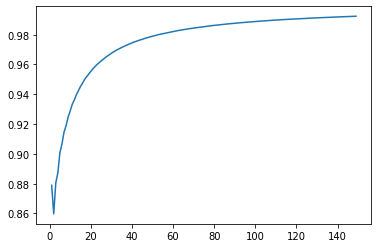

In [ ]:
np.random.seed(42)

n_trees = 150
best_est = 0
i = 0
cv_scores = np.empty((5, n_trees - 1))

for train_index, test_index in kf.split(X_num):
    X_train, X_test = X_num[train_index], X_num[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf3 = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    clf3.fit(X_num, y)
    estimators = clf3.estimators_
    test_roc_auc = np.array([])
    mean_scores = np.array([])
    for n in range(1, n_trees):
      clf3.estimators_ = np.random.choice(estimators, n)
      test_roc_auc = np.append(test_roc_auc, roc_auc_score(y_test, clf3.predict(X_test)))
      mean_scores = np.append(mean_scores, test_roc_auc.mean())
    cv_scores[i] = mean_scores
    i += 1


plt.plot(np.arange(1, n_trees, 1), cv_scores.mean(axis=0))
plt.show()

In [ ]:
best_est = np.argmax(abs(np.diff(cv_scores.mean(axis=0))) < 0.001)
clf3 = RandomForestClassifier(n_estimators=best_est, random_state=42)
best_score = cross_val_score(clf3, X_num, y, cv=kf).mean()
best_est, best_score

(26, 0.8117551049000035)

  0%|          | 0/35 [00:00<?, ?it/s]

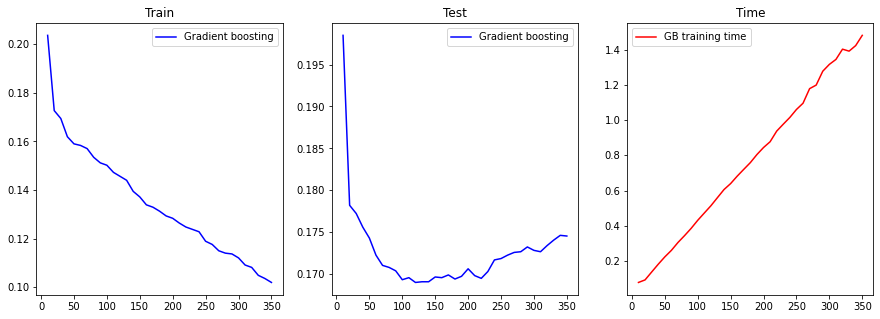

In [ ]:
acc_train, acc_test, time_list, best_grid_est1 = get_model_scores(GradientBoostingClassifier)
params = {1: [acc_train, 'Gradient boosting', 'Train'], 
          2: [acc_test, 'Gradient boosting', 'Test'], 
          3: [time_list, "GB training time", 'Time']}

plot_graphs(params)

In [ ]:
clf4 = GradientBoostingClassifier(n_estimators=best_grid_est, random_state=42)
best_grid_score = cross_val_score(clf4, X_num, y, cv=kf).mean()
best_grid_est, best_grid_score

(120, 0.8320847011673953)

Изменилось ли качество у некоторых алгоритмов?

Как и предполагалось, качество sgd и knn классификаторов выросло

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [ ]:
clf0 = KNeighborsClassifier()
params0 = {'n_neighbors': np.arange(1, 16, 1),
           'metric': ('euclidean', 'manhattan', 'chebyshev', 'minkowski', 
                      'wminkowski', 'seuclidean', 'mahalanobis')}
grid = GridSearchCV(clf0, params0, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'metric': 'euclidean', 'n_neighbors': 15}
best score: 0.8119456832240648 



In [ ]:
clf1 = DecisionTreeClassifier(random_state=42)
params1 = {'max_depth': np.arange(1, 11, 1),
           'criterion': ("gini", "entropy")}
grid = GridSearchCV(clf1, params1, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'criterion': 'gini', 'max_depth': 8}
best score: 0.8376233738564988 



In [ ]:
clf2 = SGDClassifier(random_state=42)
params2 = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge',
                    'perceptron', 'squared_error', 'huber', 
                    'epsilon_insensitive', 'squared_epsilon_insensitive'), 
           'penalty': ('l2', 'l1', 'elasticnet')}
grid = GridSearchCV(clf2, params2, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_}')

best params: {'loss': 'log', 'penalty': 'elasticnet'}
best score: 0.8175900323161649


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm_notebook

clf3 = RandomForestClassifier(n_estimators=best_est, random_state=42)
params3 = {'criterion': ("gini", "entropy"), 
           'max_features': (None, "sqrt", "log2")}
grid = GridSearchCV(clf3, params3, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_}')

best params: {'criterion': 'entropy', 'max_features': 'sqrt'}
best score: 0.8234780630769697


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf4 = GradientBoostingClassifier(n_estimators=best_grid_est, random_state=42)
params4 = {'criterion': ('friedman_mse', 'squared_error', 'mse', 'mae'), 
           'max_features': (None, 'sqrt', 'log2')}
grid = GridSearchCV(clf4, params4, cv=kf, scoring='roc_auc')
grid.fit(X_num, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'criterion': 'friedman_mse', 'max_features': None}
best score: 0.8615548615443636 



Наилучшее качество -- модель градиентного бустинга 

best params: {'criterion': 'friedman_mse', 'max_features': 'sqrt'}

best score: 0.8545126184663548 

Какой из алгоритмов имеет наилучшее качество? 

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

knn, sgd и decision tree обучаются достаточно быстро.

Random forest обучается заметно медленее, т.к. это набор из n решающих деревьев

Дольше всего обучается Gradient Boosting т.к. каждое следующее дерево уменьшает ошибку предыдущего, из-за чего они строятся последовательно

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X_cat_enc = enc.fit_transform(X_cat).toarray()

**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [ ]:
X = np.append(X_num, X_cat_enc, axis=1)
X.shape

(15347, 64)

In [ ]:
clf0 = KNeighborsClassifier(metric='euclidean', n_neighbors=15)
print('Cross-validation KNeighbors score:', cross_val_score(clf0, X, y, cv=kf, scoring='roc_auc').mean())

clf1 = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
print('Cross-validation DecisionTree score:', cross_val_score(clf1, X, y, cv=kf, scoring='roc_auc').mean())

clf2 = SGDClassifier(loss='log', penalty='elasticnet', random_state=42)
print('Cross-validation SGD score:', cross_val_score(clf2, X, y, cv=kf, scoring='roc_auc').mean())

clf3 = RandomForestClassifier(n_estimators=best_est, criterion='entropy', max_features='sqrt', random_state=42)
print('Cross-validation RandomForest score:', cross_val_score(clf3, X, y, cv=kf, scoring='roc_auc').mean())

clf4 = GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features=None, random_state=42)
print('Cross-validation GradientBoosting score:', cross_val_score(clf4, X, y, cv=kf, scoring='roc_auc').mean())

Cross-validation KNeighbors score: 0.8819859346149942
Cross-validation DecisionTree score: 0.8883425630512102
Cross-validation SGD score: 0.8994184110286673
Cross-validation RandomForest score: 0.8968901847892561
Cross-validation GradientBoosting score: 0.9155435629838256


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Нет, качество всех моделей выросло, но лучшая модель осталась та же -- Градиентный бустинг

Cross-validation GradientBoosting score: 0.9155435629838256

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

Выросло качество у всех моделей кроме random forest при использовании полиномов вместе с категориальными признаками.

Лучшая модель осталась та же

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(X_num)

In [ ]:
pipe0 = Pipeline([
    ('selector', SelectKBest(score_func=mutual_info_classif, k=10)), 
    ('model', KNeighborsClassifier(metric='euclidean', n_neighbors=15))]
)

params00 = {'selector__k': np.arange(10, 20, 2),
            'selector__score_func': (f_classif, chi2, mutual_info_classif)}
grid = GridSearchCV(pipe0, params00, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')


pipe02 = Pipeline([
    ('selector', RFE(LogisticRegression(max_iter=1000), n_features_to_select=10, step=3)), 
    ('model', KNeighborsClassifier(metric='euclidean', n_neighbors=15))]
)

params02 = {'selector__n_features_to_select': np.arange(10, 20, 2),
            'selector__step': [3, 5, 10]}
grid = GridSearchCV(pipe02, params02, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')


pipe03 = Pipeline([
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), threshold=1e-5)), 
    ('model', KNeighborsClassifier(metric='euclidean', n_neighbors=15))]
)

params03 = {'selector__estimator': (LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='elasticnet', max_iter=1000, solver='liblinear'),),
            'selector__threshold': (1e-5, 1e-4)}
grid = GridSearchCV(pipe03, params03, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'selector__k': 14, 'selector__score_func': <function f_classif at 0x7fece824f200>}
best score: 0.830359024309467 

best params: {'selector__n_features_to_select': 18, 'selector__step': 10}
best score: 0.823756921678273 

best params: {'selector__estimator': LogisticRegression(max_iter=1000, solver='liblinear'), 'selector__threshold': 1e-05}
best score: 0.8112138686171301 



In [ ]:
clf0 = KNeighborsClassifier(metric='euclidean', n_neighbors=15)
selector = SelectKBest(score_func=f_classif, k=14)
X_big = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
print('Cross-validation KNeighbors score:', cross_val_score(clf0, X_big, y, cv=kf, scoring='roc_auc').mean())

Cross-validation KNeighbors score: 0.8964700111005192


In [ ]:
pipe11 = Pipeline([
    ('selector', SelectKBest(score_func=mutual_info_classif, k=10)), 
    ('model', DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42))]
)

params11 = {'selector__k': np.arange(10, 20, 2),
            'selector__score_func': (f_classif, chi2, mutual_info_classif)}
grid = GridSearchCV(pipe11, params11, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')



pipe12 = Pipeline([
    ('selector', RFE(LogisticRegression(max_iter=1000), n_features_to_select=10, step=3)), 
    ('model', DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42))]
)

params12 = {'selector__n_features_to_select': np.arange(10, 20, 2),
            'selector__step': [3, 5, 10]}
grid = GridSearchCV(pipe12, params12, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')


pipe13 = Pipeline([
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), threshold=1e-5)), 
    ('model', DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42))]
)

params13 = {'selector__estimator': (LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='elasticnet', max_iter=1000, solver='liblinear'),),
            'selector__threshold': (1e-5, 1e-4)}
grid = GridSearchCV(pipe13, params13, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'selector__k': 10, 'selector__score_func': <function f_classif at 0x7fece824f200>}
best score: 0.8465970447096458 

best params: {'selector__n_features_to_select': 12, 'selector__step': 3}
best score: 0.8475709088079488 

best params: {'selector__estimator': LogisticRegression(max_iter=1000, solver='liblinear'), 'selector__threshold': 1e-05}
best score: 0.8348916338781741 



In [ ]:
clf1 = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=12, step=3)
X_big = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
print('Cross-validation DecisionTree score:', cross_val_score(clf1, X_big, y, cv=kf, scoring='roc_auc').mean())

Cross-validation DecisionTree score: 0.8893889366292125


In [ ]:
pipe21 = Pipeline([
    ('selector', SelectKBest(score_func=mutual_info_classif, k=10)), 
    ('model', SGDClassifier(loss='log', penalty='elasticnet', random_state=42))]
)

params21 = {'selector__k': np.arange(10, 20, 2),
            'selector__score_func': (f_classif, chi2, mutual_info_classif)}
grid = GridSearchCV(pipe21, params21, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')



pipe22 = Pipeline([
    ('selector', RFE(LogisticRegression(max_iter=1000), n_features_to_select=10, step=3)), 
    ('model', SGDClassifier(loss='log', penalty='elasticnet', random_state=42))]
)

params22 = {'selector__n_features_to_select': np.arange(10, 20, 2),
            'selector__step': [3, 5, 10]}
grid = GridSearchCV(pipe22, params22, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')


pipe23 = Pipeline([
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), threshold=1e-5)), 
    ('model', SGDClassifier(loss='log', penalty='elasticnet', random_state=42))]
)

params23 = {'selector__estimator': (LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='elasticnet', max_iter=1000, solver='liblinear'),),
            'selector__threshold': (1e-5, 1e-4)}
grid = GridSearchCV(pipe23, params23, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'selector__k': 18, 'selector__score_func': <function f_classif at 0x7fece824f200>}
best score: 0.836541610203392 

best params: {'selector__n_features_to_select': 18, 'selector__step': 10}
best score: 0.8387775975923288 

best params: {'selector__estimator': LogisticRegression(max_iter=1000, solver='liblinear'), 'selector__threshold': 1e-05}
best score: 0.8220092994254429 



In [ ]:
clf2 = SGDClassifier(loss='log', penalty='elasticnet', random_state=42)
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=18, step=10)
X_big = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
print('Cross-validation SGD score:', cross_val_score(clf2, X_big, y, cv=kf, scoring='roc_auc').mean())

Cross-validation SGD score: 0.900742076158149


In [ ]:
pipe31 = Pipeline([
    ('selector', SelectKBest(score_func=mutual_info_classif, k=10)), 
    ('model', RandomForestClassifier(n_estimators=best_est, criterion='entropy', max_features='sqrt', random_state=42))]
)

params31 = {'selector__k': np.arange(10, 20, 2),
            'selector__score_func': (f_classif, chi2, mutual_info_classif)}
grid = GridSearchCV(pipe31, params31, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')



pipe32 = Pipeline([
    ('selector', RFE(LogisticRegression(max_iter=1000), n_features_to_select=10, step=3)), 
    ('model', RandomForestClassifier(n_estimators=best_est, criterion='entropy', max_features='sqrt', random_state=42))]
)

params32 = {'selector__n_features_to_select': np.arange(10, 20, 2),
            'selector__step': [3, 5, 10]}
grid = GridSearchCV(pipe32, params32, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')


pipe33 = Pipeline([
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), threshold=1e-5)), 
    ('model', RandomForestClassifier(n_estimators=best_est, criterion='entropy', max_features='sqrt', random_state=42))]
)

params33 = {'selector__estimator': (LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='elasticnet', max_iter=1000, solver='liblinear'),),
            'selector__threshold': (1e-5, 1e-4)}
grid = GridSearchCV(pipe33, params33, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'selector__k': 10, 'selector__score_func': <function f_classif at 0x7fece824f200>}
best score: 0.8220182605977028 

best params: {'selector__n_features_to_select': 10, 'selector__step': 3}
best score: 0.817457555548349 

best params: {'selector__estimator': LogisticRegression(max_iter=1000, solver='liblinear'), 'selector__threshold': 1e-05}
best score: 0.8222466358852139 



In [ ]:
clf3 = RandomForestClassifier(n_estimators=best_est, criterion='entropy', max_features='sqrt', random_state=42)
selector = SelectKBest(score_func=f_classif, k=10)
X_big = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
print('Cross-validation RandomForest score:', cross_val_score(clf3, X_big, y, cv=kf, scoring='roc_auc').mean())

Cross-validation RandomForest score: 0.8911586951804751


In [ ]:
pipe41 = Pipeline([
    ('selector', SelectKBest(score_func=mutual_info_classif, k=10)), 
    ('model', GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features='sqrt', random_state=42))]
)

params41 = {'selector__k': np.arange(10, 20, 2),
            'selector__score_func': (f_classif, chi2, mutual_info_classif)}
grid = GridSearchCV(pipe41, params41, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')



pipe42 = Pipeline([
    ('selector', RFE(LogisticRegression(max_iter=1000), n_features_to_select=10, step=3)), 
    ('model', GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features='sqrt', random_state=42))]
)

params42 = {'selector__n_features_to_select': np.arange(10, 20, 2),
            'selector__step': [3, 5, 10]}
grid = GridSearchCV(pipe42, params42, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')


pipe43 = Pipeline([
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), threshold=1e-5)), 
    ('model', GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features='sqrt', random_state=42))]
)

params43 = {'selector__estimator': (LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear'),
                                    LogisticRegression(penalty='elasticnet', max_iter=1000, solver='liblinear'),),
            'selector__threshold': (1e-5, 1e-4)}
grid = GridSearchCV(pipe33, params33, cv=kf, scoring='roc_auc')
grid.fit(X_poly, y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

best params: {'selector__k': 10, 'selector__score_func': <function f_classif at 0x7fece824f200>}
best score: 0.8644807752188199 

best params: {'selector__n_features_to_select': 10, 'selector__step': 3}
best score: 0.8617376207530916 

best params: {'selector__estimator': LogisticRegression(max_iter=1000, solver='liblinear'), 'selector__threshold': 1e-05}
best score: 0.8222466358852139 



In [ ]:
clf4 = GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features=None, random_state=42)
selector = SelectKBest(score_func=f_classif, k=10)
X_big = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
print('Cross-validation GradientBoosting score:', cross_val_score(clf4, X_big, y, cv=kf, scoring='roc_auc').mean())

Cross-validation GradientBoosting score: 0.9210674582151205


## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

Лучшие модели:

SGDClassifier(loss='log', penalty='elasticnet') 

и

GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features='sqrt')

Обученные на данных из пункта 11 (с категориальными)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin


def final_x(X, clf=4):
  if clf == 0:
    selector = SelectKBest(score_func=f_classif, k=14)
    X_ = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
    return X_
  elif clf == 1:
    selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=12, step=3)
    X_ = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
    return X_
  elif clf == 2:
    selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=18, step=10)
    X_ = np.append(selector.fit_transform(X_poly, y), X_cat_enc, axis=1)
    return X_
  elif clf == 4:
    selector = SelectKBest(score_func=f_classif, k=10)
    X_ = np.append(selector.fit_transform(X, y), X_cat_enc, axis=1)
    return X_


class SGD_GradientBoostingBlender(BaseEstimator, ClassifierMixin):
  def __init__(self, alpha=0):
    self.alpha = alpha
    self.bound = 0.5
  def fit(self, X, y):
    self.clf2 = SGDClassifier(loss='log', penalty='elasticnet', random_state=42)
    self.clf2.fit(X, y)
    self.clf4 = GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features=None, random_state=42)
    self.clf4.fit(X, y)
    self.classes_ = y.unique()
    return self
  def predict(self, X):
    self.sgd = self.clf2.predict_proba(X)
    self.gb = self.clf4.predict_proba(X)
    self.pred_proba = self.sgd * self.alpha + self.gb * (1 - self.alpha)
    self.pred = np.multiply(self.pred_proba[:, 1] > self.bound, 1)
    return self.pred
  def predict_proba(self, X):
    self.sgd = self.clf2.predict_proba(X)
    self.gb = self.clf4.predict_proba(X)
    self.pred_proba = self.sgd * self.alpha + self.gb * (1 - self.alpha)
    return self.pred_proba

In [ ]:
blend = SGD_GradientBoostingBlender()
cross_val_score(blend, final_x(X_poly), y, cv=kf, scoring='roc_auc', error_score='raise')

array([0.92072856, 0.92103043, 0.92220058, 0.92081011, 0.92056762])

best params: {'alpha': 0.0}
best score: 0.9210674582151205 



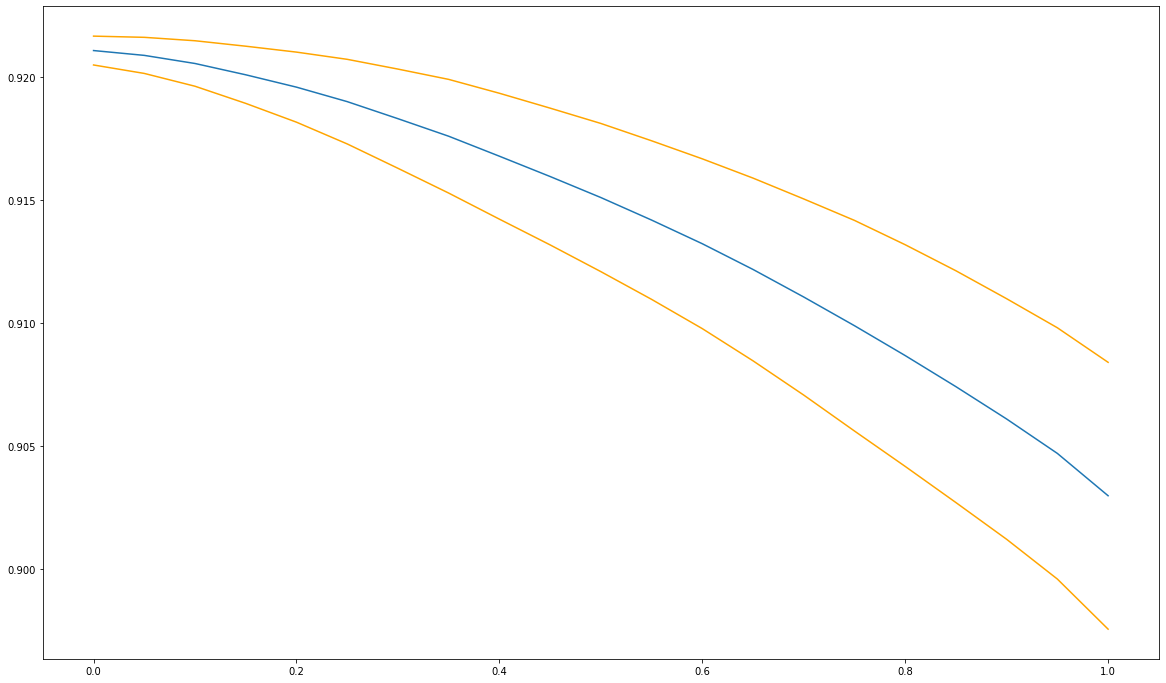

In [ ]:
blend = SGD_GradientBoostingBlender()
my_params = {'alpha': np.arange(0, 1.05, 0.05)}
grid = GridSearchCV(blend, my_params, cv=kf, scoring='roc_auc')
grid.fit(final_x(X_poly), y)
print(f'best params: {grid.best_params_}')
print(f'best score: {grid.best_score_} \n')

scores = grid.cv_results_['mean_test_score']
stds = []
for i in range(4, -1, -1):
  stds.append(grid.cv_results_[f'split{i}_test_score'])
stds = np.array(stds).std(0)
upper = scores + stds
lower = scores - stds
plt.plot(np.arange(0, 1.05, 0.05), scores)
plt.plot(np.arange(0, 1.05, 0.05), upper, color='orange')
plt.plot(np.arange(0, 1.05, 0.05), lower, color='orange')

Оптимальное значение alpha -- 0

Не получилось увеличить качество за счет смешивания моделей



## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

Text(0, 0.5, 'Probability')

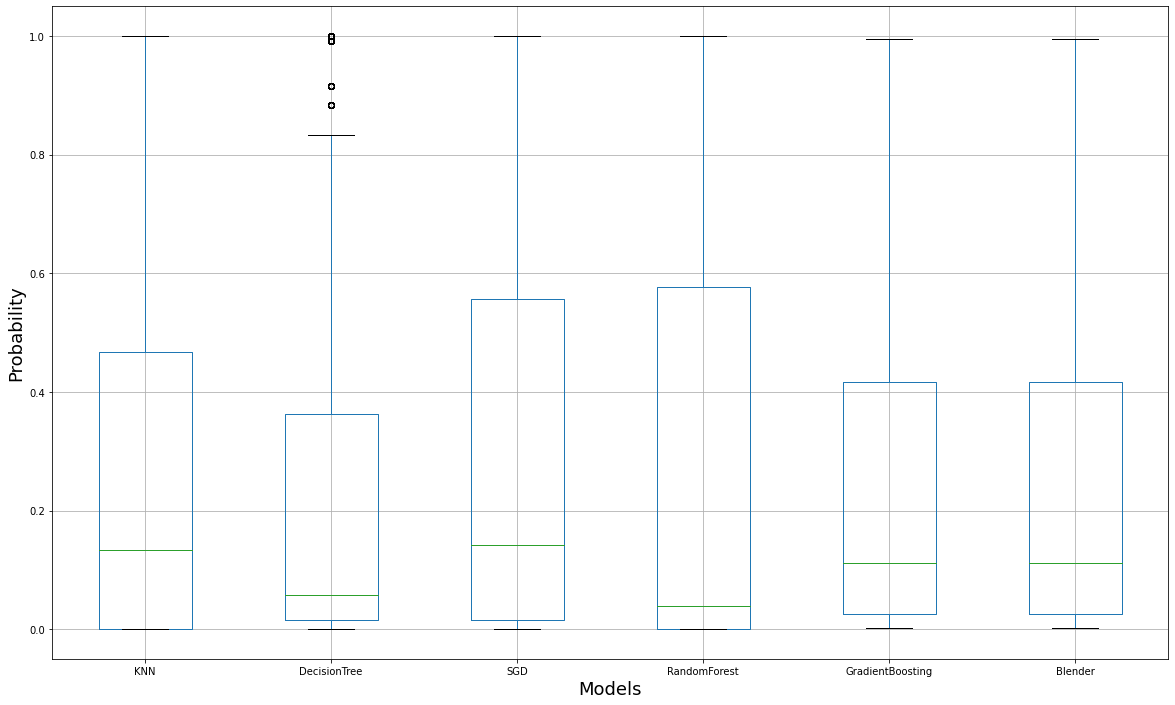

In [ ]:
plt.rcParams["figure.figsize"] = (20, 12)

preds = pd.DataFrame()

clf0 = KNeighborsClassifier(metric='euclidean', n_neighbors=15)
clf1 = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
clf2 = SGDClassifier(loss='log', penalty='elasticnet', random_state=42)
clf3 = RandomForestClassifier(n_estimators=best_est, criterion='entropy', max_features='sqrt', random_state=42)
clf4 = GradientBoostingClassifier(n_estimators=best_grid_est, criterion='friedman_mse', max_features=None, random_state=42)
blend = SGD_GradientBoostingBlender()


preds['KNN'] = clf0.fit(final_x(X_poly, 0), y).predict_proba(final_x(X_poly, 0))[:, 1]
preds['DecisionTree'] = clf1.fit(final_x(X_poly, 1), y).predict_proba(final_x(X_poly, 1))[:, 1]
preds['SGD'] = clf2.fit(final_x(X_poly, 2), y).predict_proba(final_x(X_poly, 2))[:, 1]
preds['RandomForest'] = clf3.fit(X, y).predict_proba(X)[:, 1]
preds['GradientBoosting'] = clf4.fit(final_x(X_poly, 4), y).predict_proba(final_x(X_poly, 4))[:, 1]
preds['Blender'] = blend.fit(final_x(X_poly), y).predict_proba(final_x(X_poly))[:, 1]

preds.boxplot()
plt.xlabel('Models', fontsize=18)
plt.ylabel('Probability', fontsize=18)

В целом наилучший результат дала модель, с наибольшим сроком обучения (что логично).

Изменение гиперпараметров существенно повлияло на качество моделей, увеличив их

